In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import cm, pyplot as plt
from matplotlib.dates import DayLocator
from hmmlearn.hmm import GaussianHMM

In [2]:
# load the data
bitcoin = pd.read_csv('bitcoin.csv')
bitcoin_train = pd.read_csv('bitcoin_train.csv')
bitcoin_test = pd.read_csv('bitcoin_test.csv')
xdate_train = np.array([datetime.strptime(d,'%Y-%m-%d').date() for d in bitcoin_train.Date])
xdate_test = np.array([datetime.strptime(d,'%Y-%m-%d').date() for d in bitcoin_test.Date])

In [3]:
# train and test set

def extract_feature(dataset):
    return np.column_stack([dataset['ret']])

X_train = np.column_stack([bitcoin_train['ret']])
X_test = np.column_stack([bitcoin_test['ret']])
# X= np.column_stack([ret, volume])

## Fit the HMM model
### feature: return value

In [4]:
# initial a GaussianHMM

## hidden_state_number to choose
# hidden_state = [1,2,3,4,5,6]

## assume the we have 3 hidden state: up stable down
hidden_state = 3 

model = GaussianHMM(n_components=hidden_state, n_iter=50,  verbose=True)
model.fit(X_train)

         1         535.5455             +nan
         2         634.3933         +98.8478
         3         644.4230         +10.0297
         4         651.4816          +7.0586
         5         656.3810          +4.8994
         6         659.7058          +3.3247
         7         661.9914          +2.2857
         8         663.6516          +1.6602
         9         664.9532          +1.3016
        10         666.0499          +1.0967
        11         667.0250          +0.9751
        12         667.9218          +0.8969
        13         668.7629          +0.8411
        14         669.5604          +0.7974
        15         670.3214          +0.7610
        16         671.0512          +0.7298
        17         671.7534          +0.7022
        18         672.4294          +0.6761
        19         673.0775          +0.6480
        20         673.6909          +0.6134
        21         674.2587          +0.5678
        22         674.7671          +0.5084
        23

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=50, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [5]:
# mean matrix of the hidden states
# Baum-Welch 
print("Model means under 3 hidden states: ")
print(model.means_)

# conclusion:
## 3 rows stand for 3 hidden states
## mean of the return value of each state (up stable dowm)

Model means under 3 hidden states: 
[[-0.01816431]
 [ 0.01219119]
 [ 0.03743913]]


In [6]:
# Covariance matrix
print("Covariance means: ")
print(model.covars_)

Covariance means: 
[[[0.00360594]]

 [[0.00089019]]

 [[0.00805353]]]


In [7]:
# Transition matrix of 3 states
print("Transition matrix: ")
print(model.transmat_)

### 1 2 3
# 1
# 2
# 3

Transition matrix: 
[[0.68072554 0.05253911 0.26673535]
 [0.02111615 0.94107808 0.03780577]
 [0.64651065 0.15115172 0.20233763]]


In [8]:
print("Means and vars of each hidden state")
params = pd.DataFrame(columns = ('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i], np.diag(model.covars_[i])]
params

Means and vars of each hidden state


,State,Means,Variance
0,0,[-0.01816431130520768],[0.0036059414275338383]
1,1,[0.012191185769632094],[0.000890185173778814]
2,2,[0.03743913425214689],[0.008053525072605051]


### can predict the most likely hidden states for an observed return seq

In [9]:
# The future state?
model.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1])

## Prediction

### 1  discretization for the possible outcome

0.2524717489416797 -0.18741098081435448


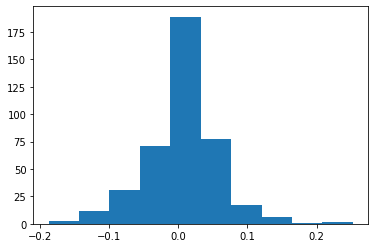

In [10]:
tmp = bitcoin_train['ret']
plt.hist(tmp)
print (max(tmp), min(tmp))
# print(tmp)

In [18]:
# possible outcomes params
tmp = pd.DataFrame(columns = ['Min', 'Max', 'Number of points'], index= ['return'])
tmp.loc['return'] = [-0.3, 0.3, 600] 
print(tmp)


possible_outcomes = np.linspace(-0.3, 0.3, 600)
import itertools
_possible_outcomes = np.array(list(itertools.product(possible_outcomes)))
# _possible_outcomes

        Min  Max Number of points
return -0.3  0.3              600


### 2 get most possible outcome and predict

In [12]:
def get_most_possible_outcome(dataset):
    previous = extract_feature(dataset)
    outcome_score = []
    for possible_outcome in _possible_outcomes:
        total_data = np.row_stack((previous, possible_outcome))
        outcome_score.append(model.score(total_data))
    most_probable_outcome = _possible_outcomes[np.argmax(outcome_score)]
    return most_probable_outcome

def one_day_predict(dataset):
    predict_return = get_most_possible_outcome(dataset)
    predict_closing = list(dataset['Close'])[-1] * (1 + predict_return)
    return predict_return, predict_closing

In [13]:
def trim(bitcoin):
    new = pd.DataFrame()
    new['Close'] = bitcoin['Close']
    new['ret'] = bitcoin['ret']
    return new

cur_set = trim(bitcoin_train)

In [14]:
n_days = len(bitcoin_test)
pclose = []
pret = []

for i in range(n_days):
    cur_pret, cur_pclosing = one_day_predict(cur_set)
    cur_set.loc[cur_set.shape[0]] = [cur_pclosing, cur_pret]
    pclose.append(cur_pclosing)
    pret.append(cur_pret)

In [15]:
pret

[array([0.00350584]),
 array([0.00851419]),
 array([0.01051753]),
 array([0.0115192]),
 array([0.0115192]),
 array([0.0115192]),
 array([0.01252087])]

C:\Users\W\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


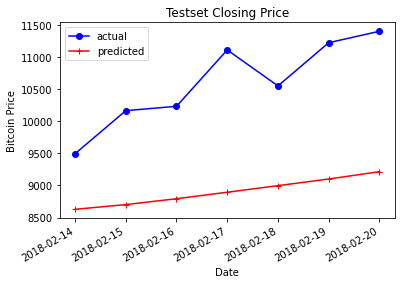

In [16]:
plt.plot(xdate_test, bitcoin_test['Close'], 'bo-', label="actual")
plt.plot(xdate_test, pclose, 'r+-', label="predicted")

plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Testset Closing Price")
plt.legend(loc='best')

plt.legend()
plt.show()

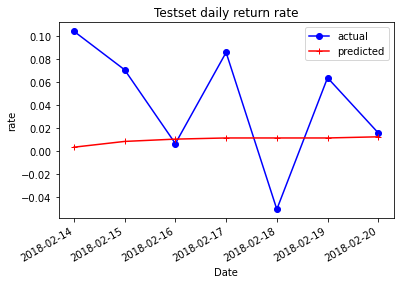

In [17]:
plt.plot(xdate_test, bitcoin_test['ret'], 'bo-', label="actual")
plt.plot(xdate_test, pret, 'r+-', label="predicted")

plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("rate")
plt.title("Testset daily return rate")
plt.legend(loc='best')

plt.legend()
plt.show()

## Q : how to predict the future return? ...
HMM package reference link:
https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.hmm.GaussianHMM

下面这个做预测时先用观测数据predict出最可能的hidden state再直接赋expected value  
比如上面喂最后7天观测数据得到最可能的hidden states 然后再赋予相应的expected return 不适用
https://blog.csdn.net/sanjianjixiang/article/details/103724117?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromBaidu-1.control&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromBaidu-1.control


似乎比较靠谱 待查看怎么实现，对应论文发群

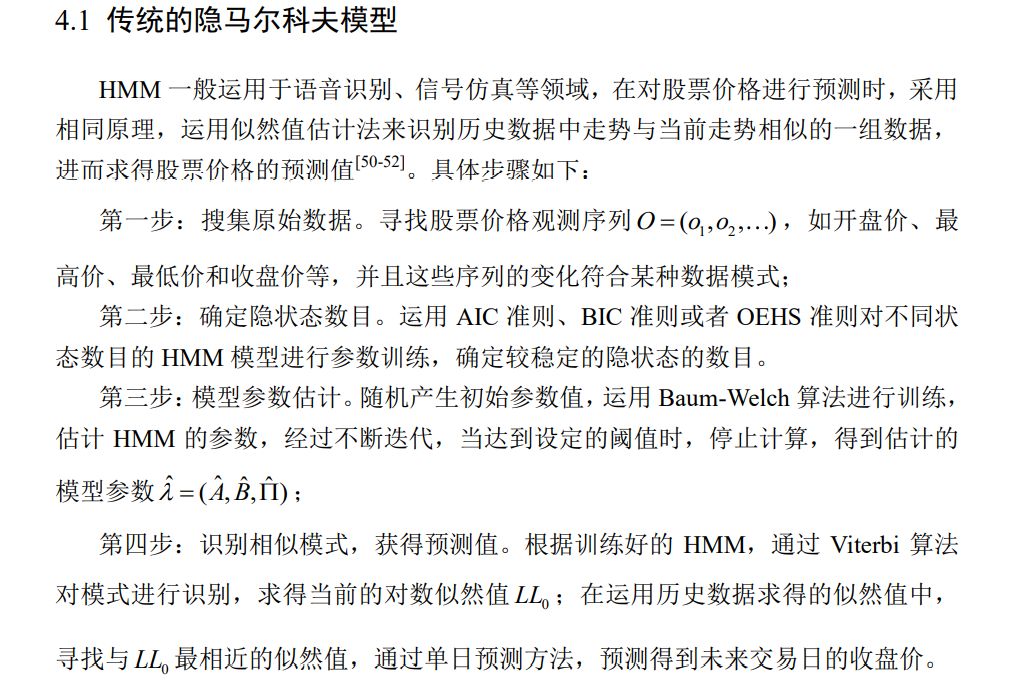